# Wildcat Farm Consultant Study - Scenario #1

## Model Description 
This intially constructs the 3D (homogeneous) steady state box model that you built for your BoxModel_Manual assignment

#### Dimensions: 
- 25 by 25 by 1
- dx = dy = 100 m
- dz = 600 m  

#### Subsurface Properties: 
- Homogeneous 
- K[:, 0:6, :] = 1.25 m/day in x, y and z 
- K[:, 6:16, :] = 6 m/day in x, y and z 
- K[:, 16:26, :] = 10.7 m/day in x, y and z 
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is constant head of 549.8 m relative to the datum, which is located at the bottom of the domain.  
 - Left boundary is a constant head of 595.2 m relative to the datum, which is located at the bottom of the domain. 

## 1. Setup the environment

In [35]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Create the model object

In [36]:
modelname = "HW7_WildcatFarm1"
moddir = "../../mf2005" #Update this path if necessary, with the path where you have your own "mp2005" file.
m = flopy.modflow.Modflow(modelname, exe_name = moddir)
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"


In [37]:
#optional delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    #file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [38]:
nrow = 25 #number of rows
ncol = 25 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 600    #top elevation is the thickness of the aquifer
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

#### 3.2 Temporal discretization 

In [39]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#### 3.3 Create DIS object

In [40]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

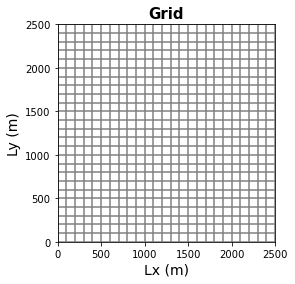

In [41]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [42]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#### 4.2 Define starting heads 

In [43]:
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0

WTD_left = 4.8 #water table depth on the left boundary, taken from the observation well on the left
WTD_right = 50.2  #water table depth on the right boundary, taken from the observation well on the right

H_left = ztop - WTD_left # Left boundary constant head value
H_right = ztop - WTD_right  # Right boundary constant head value
H_init[:, :, 0] = H_left  # replace first (left) col with desired head value
H_init[:, :, -1] = H_right  # replace first (left) col with desired head value

#print("starting head values: \n", H_init)


#### 4.3 Create BAS object

In [44]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

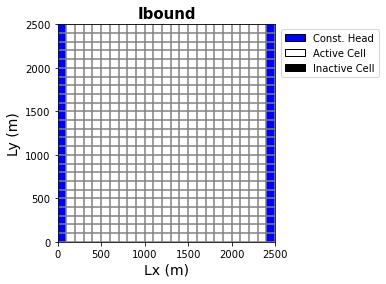

In [45]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 5. Setup Layer Properties (LPF or BCF packages)

There are two packages that can be used for the **LPF** and **BCF**. They are very similar but have some different options for layer types and controling connections between layers. 

- For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html
- For more details on BCF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html
  
Note that both are setup below but only one is actually being called. 

#### 5.1 Set layer properties
Setting up arrays for the K field and they layer type

**NOTE: Layer type options differ between the LPF anc BCF packages**

In [46]:
K_vals = np.zeros((nlay, nrow, ncol))
K_vals[:, 0:6, :] = (1.5+1)/2    # horizontal K values for top half of the domain
K_vals[:, 6:16, :] = 6    # horizontal K values for bottom half of th domain
K_vals[:, 16:25, :] = (13+8.4)/2    # horizontal K values for bottom half of th domain

K_vert = 1     #Either the value of hvertical K or the ratio of horizontal to vertical K (refer to documentation_)

n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
laytype = 1       #0=confined, >0 = convertible (for the LPF file)


#### 5.2 Plot the K field

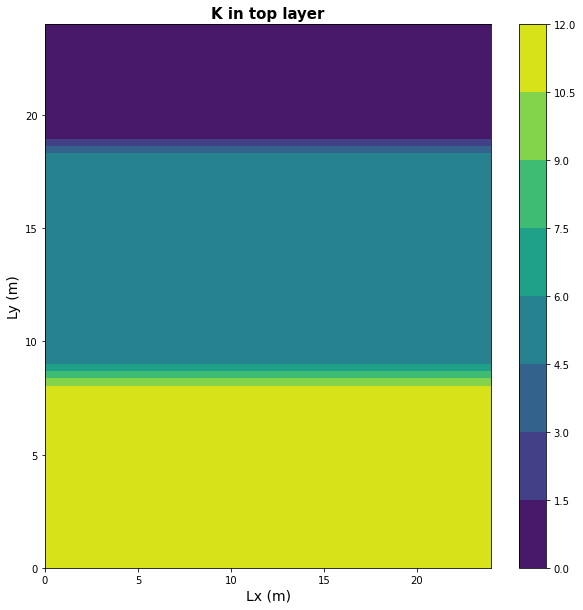

In [47]:
#plot K values in top layer
fig1 = plt.figure(figsize=(10, 10))  # create 10 x 10 figure
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
plt.title('K in top layer', fontsize=15, fontweight='bold')
plt.contourf(np.flipud(K_vals[0, :, :]))
plt.colorbar()
plt.show()

#### 5.3a  Make LPF object

In [48]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
lpf = flopy.modflow.ModflowLpf(m, laytyp=laytype, hk=K_vals, 
                                vka=K_vert, ss=Ss,
                                sy=Sy,storagecoefficient=True, ipakcb=53) 


#### 5.3.b Make BCF object

In [49]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
#bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [50]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### 6.2 Make OC object 

In [51]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [52]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [53]:
Q_wildcat = -348.08                         #total volumetric flow extracted in the well of Wildcat Farm (m3/day)
fluxes = [0,8,3,Q_wildcat]                #locating the well in the middle of Wildcat Farm

Q_acme = -10459.92/2                        #volumetric flow extracted in one well for ACME Farm (m3/day)                 
fluxes = [0,5,7,Q_acme/2]                #locating the first well in the top top-left corner of ACME Farm
fluxes = [0,24,7,Q_acme/2]                #locating the second well in the top bottom-left corner of ACME Farm.  Second well is extracting the same volumetric flow as the first well (Q_acme)


sp_fluxes = {0: fluxes}              #create a dictionary with entries for each stress period

#print(sp_fluxes)

#### 8.2 Make the WEL object

In [54]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=sp_fluxes)  #create object for WEL package

## 9. Add recharge (RCH Package)

For more details on the recharge package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfrch.html

#### 9.1 Setup recharge value

In [55]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)     

cotton_consumption = 2.867e-3         # m/d
alfalfa_consumption = 5.1705e-3          # m/d
crop_efficiency = 0.8

irrigation_wildcat = cotton_consumption/crop_efficiency
recharge_wildcat = irrigation_wildcat * (1-crop_efficiency)  #m/day
irrigation_acme = alfalfa_consumption/crop_efficiency
recharge_acme = irrigation_acme * (1-crop_efficiency)   #m/day

print("Wildcat Farm recharge (Cotton Excess Irrigation) is =", recharge_wildcat, "m/d")
print("Wildcat Farm recharge (Alfalfa Excess Irrigation) is =", recharge_acme, "m/d")

rech_zone[:,:] = 1e-4 #net recharge in non-irrigated areas
rech_zone[6:11,2:6] = recharge_wildcat #Recharge is applied to the farms territory
rech_zone[5:25,7:18] = recharge_acme

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


Wildcat Farm recharge (Cotton Excess Irrigation) is = 0.0007167499999999998 m/d
Wildcat Farm recharge (Alfalfa Excess Irrigation) is = 0.0012926249999999995 m/d


#### 9.2 Add evapotranspiration
For more details on the evapotranspiraiton package see the flopy and modflow documentation: 
- https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfevt.html 
- https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?evt.htm 
- https://pubs.usgs.gov/tm/2005/tm6A16/PDF.htm (refer to chapter 6)



In [56]:
#ET
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
bkgndET = 5e-5  #set background ET value m/day
ET_zone = ET_zone + bkgndET  #apply background ET to the entire domain 

extinction_depth = 3
#extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [57]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [58]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: HW7_WildcatFarm1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/03/20 11:10:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/20 11:10:48
 Elapsed run time:  0.016 Seconds

  Normal termination of simulation


## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads 

In [59]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

##### Write Heads as csv

In [60]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])


### Read the Water balance and get the heads, ET and Recharge

In [61]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps
#dummy = budgobj.list_records()


#Get the ET from the cell budget files
et = budgobj.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[1,:,:] #This is a matrix of the ET fluxes [m3/day]
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge = budgobj.get_data(text='recharge', totim=1.0)
recharge_vals = np.squeeze(recharge)[1,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux =', left_tot, " Right_flux=", right_tot)


Total ET [m3/day]: 0.0
Total Recharge [m3/day]: 3322.1248817443848
Left Flux = 177539.12  Right_flux= 178246.28


### Hydrologic Balance
Is Inflow - Outflow = 0 ?

In [62]:
Inflow = left_tot + rch_tot 
Outflow = right_tot + et_tot + Q_wildcat + Q_acme
print('Inflow - Outflow = ', Inflow-Outflow)

Inflow - Outflow =  8193.008631744364


### Plot ET Rcharge and WTD

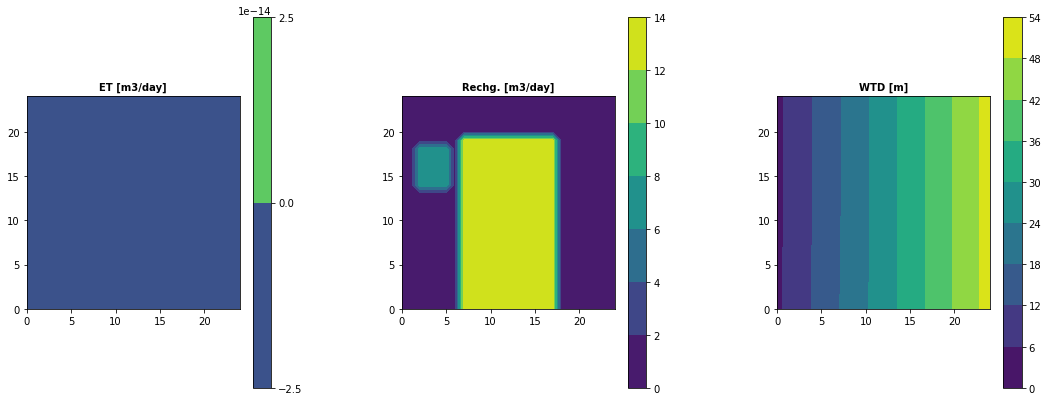

In [63]:
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.tight_layout(pad=1.0)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.6)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.6)


#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.6)
fig.set_size_inches(16, 10)

plt.show()


### Plot the boundary flows

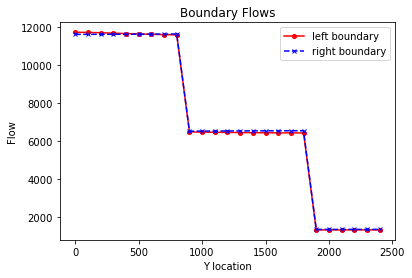

In [64]:
bdryflux_fig = plt.figure() 
ylocs=np.arange(0,ncol*dy, dy) 
plt.plot(ylocs, np.flip(leftflux),marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(ylocs, np.flip(rightflux),marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.xlabel('Y location')
plt.ylabel('Flow')
plt.title("Boundary Flows")
plt.legend()
plt.show()

#### 11.2 Evaluate the head gradients

Head Gradient 0.018160009765625 m/m


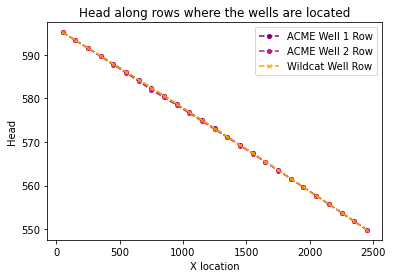

In [65]:
head_fig = plt.figure() 
xcenters=np.arange(dx/2,ncol*dx,dx) 
headplot=head[0,8,:] #Head along the row that contains the Wildcat well
headplot2=head[0,5,:] #Head along the row that contains the ACME well #1
headplot3=head[0,24,:] #Head along the row that contains the ACME well #2


plt.plot(xcenters,headplot2,marker='o', color='purple', markersize=4, linestyle='--', label='ACME Well 1 Row')
plt.plot(xcenters,headplot3,marker='o', color='mediumvioletred', markersize=4, linestyle='--', label='ACME Well 2 Row')
plt.plot(xcenters,headplot,marker='x', color='orange', markersize=4, linestyle='--', label='Wildcat Well Row')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()
plt.title("Head along rows where the wells are located")
#plt.axvline(x=1200)

#Save figure
# plt.savefig('Head_Transect.png') #save figure as a png

hgrad=(head[0,5,0]-head[0,5,-1])/Lx
print("Head Gradient", hgrad, "m/m") 


#### 11.3 3D plot of heads

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_28456\1678668645.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


Text(0.5, 0.92, 'Steady-State Model Head Profile')

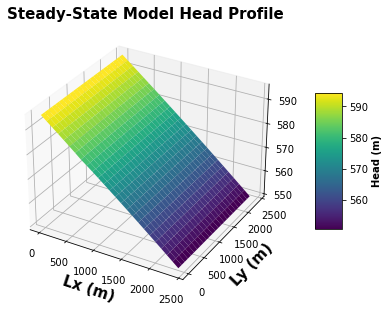

In [66]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

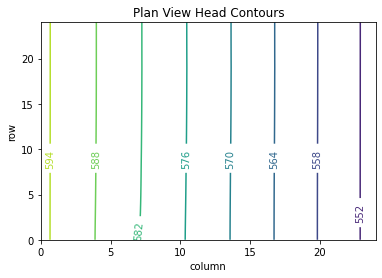

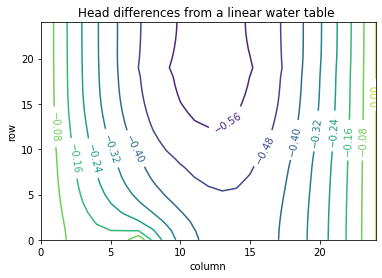

In [67]:
#create 2d figure - note, axes relate to well being defined as layer, row, column, flux
CS=plt.contour(np.flipud(head[0]))
plt.xlabel("column")
plt.ylabel("row")
plt.title("Plan View Head Contours")
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

# calculate linear head drop (no pumping)
bkgnd_head=np.linspace(H_left,H_right,ncol)
bkgnd_head=np.tile(bkgnd_head,(ncol,1))
CS=plt.contour(np.flipud(bkgnd_head-head[0]))
plt.xlabel("column")
plt.ylabel("row")
plt.title("Head differences from a linear water table ")
plt.clabel(CS, inline=1, fontsize=10)
plt.show()


####  11.4 Contour Head plot

C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


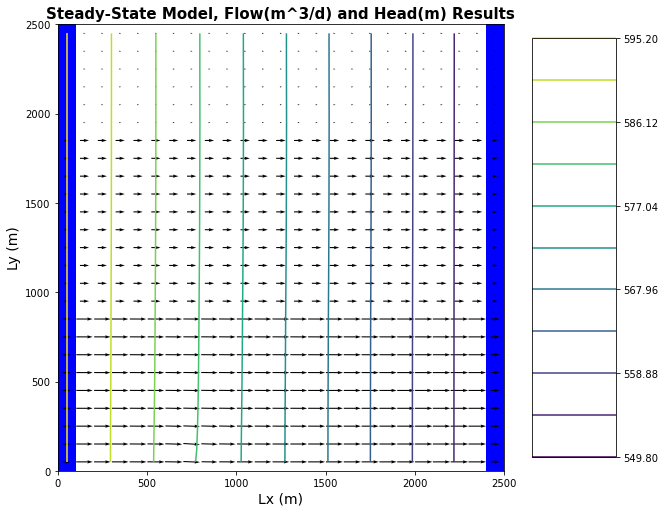

In [68]:
#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)